In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col

spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

# steam_reviews_filepath = "../data/cleaned_steam_reviews/game_id={70,240,420,620}"
steam_reviews_filepath = "../data/cleaned_steam_reviews"
steam_games_filepath = "../data/cleaned_steam_games"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 15:54:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/07 15:54:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Data

In [2]:
steam_reviews = spark.read.parquet(steam_reviews_filepath)

In [3]:
steam_games = spark.read.parquet(steam_games_filepath)

steam_games.printSchema()

root
 |-- url: string (nullable = true)
 |-- types: string (nullable = true)
 |-- name: string (nullable = true)
 |-- desc_snippet: string (nullable = true)
 |-- recent_reviews: string (nullable = true)
 |-- all_reviews: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- popular_tags: string (nullable = true)
 |-- game_details: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- achievements: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- game_description: string (nullable = true)
 |-- mature_content: string (nullable = true)
 |-- minimum_requirements: string (nullable = true)
 |-- recommended_requirements: string (nullable = true)
 |-- original_price: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- game_id: string (nullable = true)



In [10]:
steam_games.select([F.count(F.when(~F.isnull(c), c)).alias(c) for c in steam_games.columns]).show()


+-----+-----+-----+------------+--------------+-----------+------------+---------+---------+------------+------------+---------+------------+-----+----------------+--------------+--------------------+------------------------+--------------+--------------+-------+
|  url|types| name|desc_snippet|recent_reviews|all_reviews|release_date|developer|publisher|popular_tags|game_details|languages|achievements|genre|game_description|mature_content|minimum_requirements|recommended_requirements|original_price|discount_price|game_id|
+-----+-----+-----+------------+--------------+-----------+------------+---------+---------+------------+------------+---------+------------+-----+----------------+--------------+--------------------+------------------------+--------------+--------------+-------+
|38020|38020|38020|       37981|          3275|      28281|         391|    37619|    32985|       37855|       37541|    27222|        9646|26760|           26999|          5255|               16703|        

In [11]:
steam_games.select("release_date").distinct().show()

+------------+
|release_date|
+------------+
|  2016-01-01|
|        null|
|  2017-01-01|
|  2021-01-01|
|  2019-01-01|
|  2020-01-01|
|  2018-01-01|
|  2022-01-01|
|  2019-03-01|
+------------+



In [7]:
steam_games.where(steam_games['release_date'].isNotNull()).orderBy(F.desc(steam_games['release_date'])).show(100)

+--------------------+-----+--------------------+--------------------+--------------+-----------+------------+------------------------+------------------------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+-------+
|                 url|types|                name|        desc_snippet|recent_reviews|all_reviews|release_date|               developer|                           publisher|        popular_tags|        game_details|           languages|achievements|               genre|    game_description|      mature_content|minimum_requirements|recommended_requirements|      original_price|      discount_price|game_id|
+--------------------+-----+--------------------+--------------------+--------------+-----------+------------+------------------------+------------------------------------+------------

## Steam Reviews

In [13]:
def get_game_statistics_by_review_players(steam_reviews):
    playerTypeData = steam_reviews.select("app_id", "app_name", "author_steamid",
                                            "author_num_games_owned", "author_num_reviews", "author_playtime_forever",
                                            "author_playtime_last_two_weeks", "author_playtime_at_review", "author_last_played") \
                                    .where(col("author_steamid").isNotNull() \
                                                    & col("author_num_games_owned").isNotNull() \
                                                    & (col("author_num_reviews").isNotNull()) \
                                                    & (col("author_playtime_forever").isNotNull()) \
                                                    & (col("author_playtime_last_two_weeks").isNotNull()) \
                                                    & (col("author_playtime_at_review").isNotNull()) \
                                                    & (col("author_last_played").isNotNull())  )
    
    gameName = playerTypeData.select("app_id", "app_name").distinct()

    playerType = playerTypeData.groupBy(col("app_id")) \
                                .agg( \
                                    F.count("author_steamid").alias("review_count"), \
                                    F.avg("author_num_games_owned").alias("avg_num_games_owned"), \
                                    F.avg("author_num_reviews").alias("avg_num_reviews"), \
                                    F.avg("author_playtime_forever").alias("avg_playtime_forever"), \
                                    F.avg("author_playtime_last_two_weeks").alias("avg_playtime_last_two_weeks"), \
                                    F.avg("author_playtime_at_review").alias("avg_playtime_at_review"), \
                                    F.avg("author_last_played").alias("avg_last_played") \
                                )

    playerType = gameName.join(playerType, "app_id").orderBy(col("app_id").cast(types.IntegerType()))

    return playerType

In [16]:
playerType = get_game_statistics_by_review_players(steam_reviews)

## Join Player Type and Steam Games

In [17]:
playerType_steamGames = steam_games.join(playerType, steam_games["game_id"] == playerType["app_id"])

In [18]:
playerType_steamGames.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------+--------------+-------+------+--------------------+------------+-------------------+------------------+--------------------+---------------------------+----------------------+--------------------+
|                 url|types|                name|        desc_snippet|      recent_reviews|         all_reviews|release_date|           developer|           publisher|        popular_tags|        game_details|           languages|achievements|               genre|    game_description|      mature_content|minimum_requirements|recommended_requirements|original_price|discount_price|game_id|app_id|            app_name|review_count|avg_n

In [20]:
playerType_steamGames.count()

282

## Genres Analysis

In [52]:
genres_map = steam_games.select("game_id", F.explode_outer(F.split(col("genre"),",")).alias("genres")) \
                        .drop("genre") \
                        .where(col("genres") != F.lit("null"))

genres = genres_map.select("genres").distinct()


genres_map.show(10)

genres.show(10)

print("Number of genres:", genres.count())

+-------+--------------------+
|game_id|              genres|
+-------+--------------------+
| 674020|              Action|
| 674020|               Indie|
| 674020|        Early Access|
| 389430|              Action|
| 389430|           Adventure|
| 389430|        Free to Play|
| 389430|Massively Multipl...|
| 389430|                 RPG|
| 414870|               Indie|
| 414870|          Simulation|
+-------+--------------------+
only showing top 10 rows

+--------------------+
|              genres|
+--------------------+
|Cross-Platform Mu...|
|                  51|
|                1500|
|           Difficult|
|              Runner|
|           Education|
|        City Builder|
|                  15|
|      Steam Workshop|
|           阿屁PP314|
+--------------------+
only showing top 10 rows

Number of genres: 265


In [53]:
playerTypeByGenres = playerType.select("app_id", "review_count", "avg_num_games_owned", "avg_playtime_forever") \
                                .join(genres_map, genres_map["game_id"] == playerType["app_id"]) \
                                .drop("game_id") \
                                .withColumn("games_owned", col("avg_num_games_owned") * col("review_count")) \
                                .withColumn("playtime", col("avg_playtime_forever") * col("review_count")) \
                                .drop("avg_num_games_owned", "avg_playtime_forever")

playerTypeByGenres = playerTypeByGenres.groupBy("genres").agg( \
                                                                F.sum(col("review_count")).alias("total_review_count"), \
                                                                F.sum(col("games_owned")).alias("total_games_owned"), \
                                                                F.sum(col("playtime")).alias("total_playtime"), \
                                                            ) \
                                        .withColumn("avg_games_owned", col("total_games_owned") / col("total_review_count")) \
                                        .withColumn("avg_playtime", col("total_playtime") / col("total_review_count"))

In [63]:
playerTypeByGenres.orderBy(F.desc("avg_games_owned")).show(20)

+--------------------+------------------+-----------------+----------------+------------------+------------------+
|              genres|total_review_count|total_games_owned|  total_playtime|   avg_games_owned|      avg_playtime|
+--------------------+------------------+-----------------+----------------+------------------+------------------+
|            Strategy|           2058413|     3.05925249E8| 3.8837774008E10|148.62189900666192|18867.823905115252|
|        Early Access|            618693|      8.3312815E7|    5.99215351E9|134.65937872256515| 9685.180711596866|
|                 RPG|           4032002|     5.05164663E8| 6.8547185582E10|125.28879276349565|17000.781641973394|
|               Indie|           5885382|     7.02113375E8| 9.4790444046E10|119.29784251897328|16106.081822046555|
|        Free to Play|            108306|      1.2823618E7|    1.79454123E8|118.40173212933725|1656.9176499916903|
|          Simulation|           3211194|     3.55088611E8| 5.7704515753E10| 110

                 avg_games_owned  avg_playtime
avg_games_owned         1.000000      0.336969
avg_playtime            0.336969      1.000000


/var/folders/bn/n488fsxn7ndc1kw3hf1k47000000gn/T/ipykernel_22689/1944477113.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(genres_gamesOwned_vs_playtime.toPandas().corr())


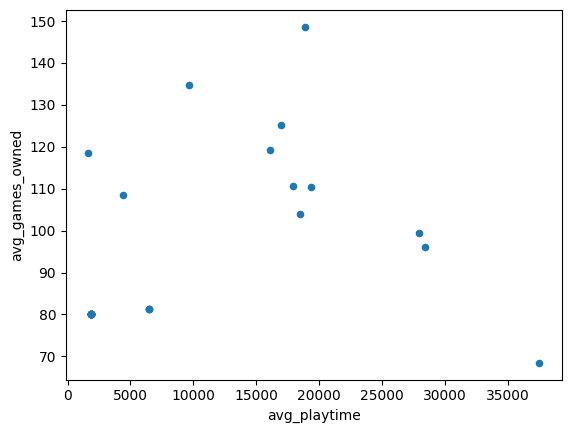

In [72]:
genres_gamesOwned_vs_playtime = playerTypeByGenres.select("genres", "avg_games_owned", "avg_playtime")
genres_gamesOwned_vs_playtime.toPandas().plot.scatter(x='avg_playtime', y='avg_games_owned')
print(genres_gamesOwned_vs_playtime.toPandas().corr())

## Popular Tags Analysis

In [39]:
tags_map = steam_games.select("game_id", F.explode_outer(F.split(col("popular_tags"),",")).alias("tags")) \
                        .drop("popular_tags") \
                        .where(col("tags") != F.lit("null"))

tags = tags_map.select("tags").distinct()


tags_map.show(10)

tags.show(10)

print("Number of tags:", tags.count())

+-------+------------+
|game_id|        tags|
+-------+------------+
| 674020|Early Access|
| 674020|         FPS|
| 674020|    Military|
| 674020|         War|
| 674020| Multiplayer|
| 674020|Early Access|
| 674020|     Shooter|
| 674020|      Action|
| 674020|First-Person|
| 674020|   Realistic|
+-------+------------+
only showing top 10 rows

+--------------------+
|                tags|
+--------------------+
|   Schmidt Workshops|
|    Carpe Fulgur LLC|
| Iceberg Interactive|
|             Match 3|
|Project ""The Gam...|
|Tunnel Vision Studio|
|              Nov 27|
|Heart Shaped Game...|
|   Specialbit Studio|
|      1 user reviews|
+--------------------+
only showing top 10 rows

Number of tags: 968


In [64]:
playerTypeByTags = playerType.select("app_id", "review_count", "avg_num_games_owned", "avg_playtime_forever") \
                            .join(tags_map, tags_map["game_id"] == playerType["app_id"]) \
                            .drop("game_id") \
                            .withColumn("games_owned", col("avg_num_games_owned") * col("review_count")) \
                            .withColumn("playtime", col("avg_playtime_forever") * col("review_count")) \
                            .drop("avg_num_games_owned", "avg_playtime_forever")

playerTypeByTags = playerTypeByTags.groupBy("tags").agg( \
                                                            F.sum(col("review_count")).alias("total_review_count"), \
                                                            F.sum(col("games_owned")).alias("total_games_owned"), \
                                                            F.sum(col("playtime")).alias("total_playtime"), \
                                                        ) \
                                    .withColumn("avg_games_owned", col("total_games_owned") / col("total_review_count")) \
                                    .withColumn("avg_playtime", col("total_playtime") / col("total_review_count"))

In [68]:
playerTypeByTags.orderBy(F.desc("avg_playtime")).show(20)

+--------------------+------------------+-----------------+--------------------+------------------+------------------+
|                tags|total_review_count|total_games_owned|      total_playtime|   avg_games_owned|      avg_playtime|
+--------------------+------------------+-----------------+--------------------+------------------+------------------+
|              MMORPG|            463851|      4.6801101E7|      1.896003512E10|100.89684187379137| 40875.27055024135|
|           Political|             95021|      1.4404076E7|       3.468652055E9|151.58834362930298| 36504.05757674619|
|           Dinosaurs|            402674|      3.8452236E7|1.432441192600000...| 95.49222447935551| 35573.22282044533|
|       Battle Royale|           1449293|      8.1423648E7|      5.074327672E10| 56.18163338952165|35012.434835468055|
|           Diplomacy|            293407|      3.9465453E7|      1.003682946E10| 134.5075373116524|34207.873227291784|
|            Baseball|               490|64514.0

                 avg_games_owned  avg_playtime
avg_games_owned         1.000000     -0.525954
avg_playtime           -0.525954      1.000000


/var/folders/bn/n488fsxn7ndc1kw3hf1k47000000gn/T/ipykernel_22689/1547959008.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(tags_gamesOwned_vs_playtime.toPandas().corr())


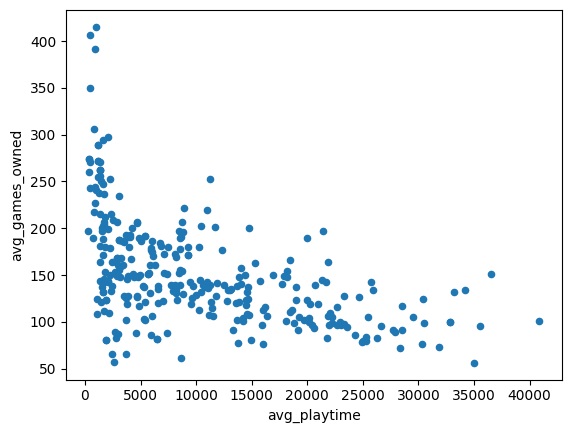

In [71]:
tags_gamesOwned_vs_playtime = playerTypeByTags.select("tags", "avg_games_owned", "avg_playtime")
tags_gamesOwned_vs_playtime.toPandas().plot.scatter(x='avg_playtime', y='avg_games_owned')
print(tags_gamesOwned_vs_playtime.toPandas().corr())